## BMEB W4020: Circuits in the Brain 2021 Fall Homework #2 Solution

Author: [Shashwat Shukla](ss6113@columbia.edu), [Bruce Yi Bu](yb2520@columbia.edu) &  [Tingkai Liiu](tl2747@columbia.edu)

Copyright 2022 Shashwat Shukla, Bruce Yi Bu, Tingkai Liu, and Aurel A. Lazar

In [1]:
# Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import typing as tp

from compneuro.neurons.hodgkin_huxley_3state import HodgkinHuxley3State
from compneuro.neurons.hodgkin_huxley import HodgkinHuxley # For Problem 2
from compneuro.synapses.ampa import AMPA
from compneuro.utils.phase_response import PIF, PRC, iPRC
from compneuro.utils.neuron import limit_cycle
from compneuro.utils.signal import spike_detect
from compneuro.base_model import BaseModel


np.random.seed(4020)  # fix random seed
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 80

## Problem 1: PRC of Reduced Hodgekin Huxley Model (Winfree's Method)

In [2]:
# TODO: Implement signal generator that takes in [time, coefficients, order, Bandwidth] as input
def bandlmt_sig(t, M, f):
    out = np.zeros_like(t)
    for i in range(1, M + 1):
        out += +2 * np.random.random() * np.cos(2 * np.pi * f * i * t / M)
        out += -2 * np.random.random() * np.sin(2 * np.pi * f * i * t / M)
    return out / np.max(np.absolute(out))

In [3]:
# TODO: Specify the time resolution for computing PRC. 
# The smaller the value the better the Winfree method performs
# NOTE: start with a smaller value to ensure the code works before making it larger

dt = 1e-6
t = np.arange(0, 0.2, dt)

# TODO: Specify the bias of HH Model (I in I_ext = I + u(t)).
# This value will be used in both the neuron model itself and its PIF.
bias = 20  # injected current
# unit is in pico amp
# we suggest refering the injection current amplitude (aka without stimulus) 
# that you've experimented with in HW1 that gives robust firing 

rhh = HodgkinHuxley3State()
t_lc, lc = limit_cycle(rhh, dt, I_ext=bias)

  0%|          | 0/1000000 [00:00<?, ?it/s]

### Part 1. Winfree's method for approximating the Phase Response Curve.

The idea is simple: we first record the limit cycle of the neuron for a given injected current between two consecutive spikes at $t_k$ and $t_{k+1}$. We then start the neuron at some time $\theta$ between $t_k$ and $t_{k+1}$ with the state variables corresponding to time $\theta$ on the previously recorded limit cycle, and the voltage is perturbed a little (by $+1mV$ in this implementation). We then simulate the neuron from this perturbed state until it fires 3 spike at some time $t'$. Note that we simulate for more than one period so that the transients from the initial perturbation die out and the neuron is sufficiently close again to the limit cycle. The PRC is then given as the $3*(t_{k+1} - t_{k}) - t'$.

In [4]:
# the implementation of PRC function is shown below
import inspect
from IPython.display import Code
Code(inspect.getsource(PRC), language='python')

def PRC(
    model: BaseModel,
    dt: float,
    verbose: bool = False,
    spike_threshold: float = 0,
    N_skip_cycles: int = 3,
    spike_variable: str = "V",
    winfree_perturb_amp: tp.Union[float, np.ndarray] = 0.1,
    winfree_steps: int = None,
    normalize: bool = False,
    normalization_bias: float = 1e-15,
    solver: str = None,
    lc: np.ndarray = None,
    limit_cycle_kws: tp.Mapping[str, tp.Any] = None,
    **injected_stimuli,
) -> tp.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute the phase response curve for a specified inject current value

    Arguments:
        model: instance of an oscillator class inherited from the parent class :code:`BaseModel`
        dt: temporal resolution for the ODE updates (in seconds)
        verbose: whether to show progress
        spike_threshold: minimum height to define the peak of a spike

            .. deprecated:: 0.1.3
                Use :code:`**limit_cycle_kws` instead

        N_skip_cycles: number of limit cycles to skip for PRC computation to settle
        spike_variable: variable corresponding to voltage in the specified :code:`model`, this
          variable is used by :py:func:`limit_cycle` to find the limit cycle of the model.
        winfree_perturb_amp: perturbation amplitude of the winfree's method. If scalar, the same
          amplitude is used for all state variables.

        .. note::

            The unit of :code:`winfree_perturb_amp` is actually (variable_unit / model_time_unit).
            In the case of voltage for Hodging-Huxley neuron, this is mili-Volt/mili-Second

        winfree_steps: number of steps to compute winfree's PRC, defaults to entire limit cycle at
          :code:`dt` resolution
        normalize: if `True`, will scale PRC by product with gradient at each point along the limit
          cycle. Since the scaling involves a division, a small bias is added to the denominator which
          could result in spikes in the normalized PRC. The bias can be controled by the
          `normalization_bias` parameter.
        normalization_bias: the bias term in the normalization of PRC, see above.
        solver: solver to use for ivp
        lc: limit cycle for the given model. If specified, the limit cycle computation is skipped.
        limit_cycle_kws: arguments to be passed into `limit_cycle` function

            .. seealso:: :py:func:"compneuro.utils.neuron.limit_cycle"

    Keyword Arguments:
        injected_stimuli: key,value pair of stimuls and constant value for that variable

    .. note::

        The model must have an ode method.
        Furthermore, the state variables of the model should be ordered such that voltage is the
        first variable.

    Returns:
        1. period: 1D array of time vector corresponding to the limit cycle
        2. limit_cycle: 2d numpy array of state variables over time
        3. prc: the desired phase response curves of shape
          :code:`(number_of_states, period_length)`
    """
    model, Model = _check_is_instance(model)

    limit_cycle_kws = {} if limit_cycle_kws is None else limit_cycle_kws
    if not hasattr(model, "ode"):
        raise err.CompNeuroUtilsError(
            "Error: this neuron model does not have an ode method"
        )

    if spike_threshold is not None:
        warn(
            (
                "spike_threshold argument is deprecated. Pass additional arguments to "
                "limit_cycle_kws as keyword arguments directly. This warning will become an "
                "error in the next minor release."
            ),
            DeprecationWarning,
        )
        if "height" not in limit_cycle_kws:
            if np.isscalar(spike_threshold):
                limit_cycle_kws.update({"height": spike_threshold})

    if lc is not None:
        assert lc.ndim == 2 and lc.shape[0] == len(
            model.Default_States
        ), f"Provided limit cycle is of shape ({lc.shape}), mismatched with model."
        t_lc = np.arange(lc.shape

In [5]:
# TODO: Simulate your model
period, limit_cycle, prc = PRC(
    rhh, I_ext=bias, dt=dt, verbose=True, winfree_steps=100, winfree_perturb_amp=[0.1, 1e-3, 1e-3]
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

PRC (Winfree) - HodgkinHuxley3State:   0%|          | 0/55728 [00:00<?, ?it/s]

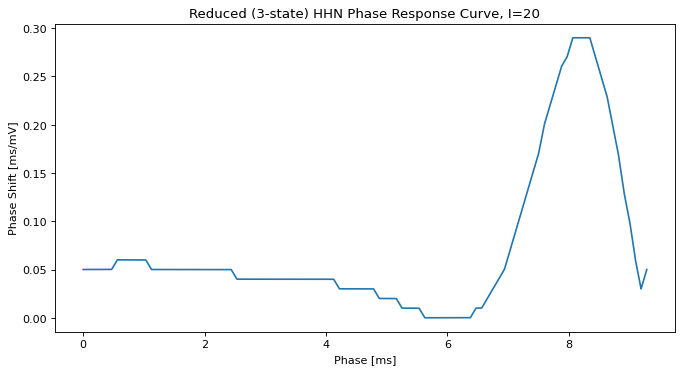

In [6]:
# TODO: Visualize the limit cycle and the PRC along it
plt.plot(1e3 * period, prc[0])
plt.title("Reduced (3-state) HHN Phase Response Curve, I={}".format(bias))
plt.xlabel("Phase [ms]")
plt.ylabel("Phase Shift [ms/mV]")
plt.show()

### Part 2. Generate spike train with RHH and the PIF neuron.

In [7]:
c = 1  # stimulus scaling factor
u = c * bandlmt_sig(t, 5, 20)  # stimulus current --> equivalent to the cell in handout
I_ext = bias + u  # external current

rhh = HodgkinHuxley3State(V=lc[0,0], n=lc[1,0], h=lc[2,0])
res = rhh.solve(t, I_ext=I_ext, verbose=True)
V_rhh = res["V"][0]

  0%|          | 0/200001 [00:00<?, ?it/s]

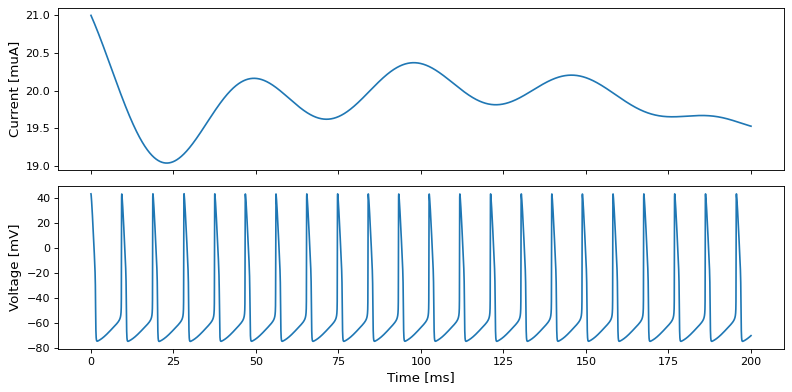

In [8]:
# TODO: simulate model and find spikes
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(1e3 * t, I_ext)
ax[0].set_ylabel("Current [muA]", fontsize=12)

ax[1].plot(1e3 * t, V_rhh)
ax[1].set_xlabel("Time [ms]", fontsize=12)
ax[1].set_ylabel("Voltage [mV]", fontsize=12)
fig.tight_layout()
plt.show()

In [9]:
# TODO: find spike time indices of RHH
ref_spikes = spike_detect(V_rhh)
ref_idx = np.where(ref_spikes)[0]

The $t$-transform:
$$ 
\int_{t_k}^{t_{k+1}}(1+\psi(s - t_k)u(s))ds = T.
$$  

In code, we integrate $(1+\psi(s)u(s))$ starting just after a spike until the integral equals $T$. The corresponding upper limit of the definite integral is the next spike-time for the PIF neuron. The integral is then reset to $0$ and the process of integrating the input begins anew from time $t_{k+1}$.

In [10]:
# TODO: Implement the PIF model using the input defined above and the PRC curve computed
Code(inspect.getsource(PIF), language='python')

def PIF(t, u, prc_V, V0=0, verbose=False):
    """Compute the voltage trace output from the equivalent project-integrate-fire (PIF) neuron

    Arguments:
        t: 1d numpy array of time vector
        u: 1d numpy array of current input
        prc_V: 1d numpy array of the phase response curve of the reference neuron
          for voltage
        V0: initial condition for voltage

    Returns:
        V: 1d numpy array of simulated output voltage trace of the PIF neuron
    """
    dt = t[1] - t[0]
    if prc_V.ndim > 1:
        raise err.CompNeuroUtilsError(
            "PRC for Voltage should be 1D array, got array with shape "
            f"{prc_V.shape} instead."
        )
    T = len(prc_V) * dt
    V = np.zeros_like(t)

    iters = enumerate(t)
    if verbose:
        iters = tqdm(iters, total=len(t), desc="PIF Neuron")

    prc_ctr = 0
    for tt, _t in iters:
        if tt == 0:
            V_old = V0
        else:
            V_old = V[tt - 1]

        d_V = 1 + prc_V[prc_ctr] * u[tt]
        V_new = V_old + dt * d_V

        prc_ctr = (prc_ctr + 1) % len(prc_V)
        if V_new >= T:
            V_new = 0
            prc_ctr = 0
        V[tt] = V_new
    return V

In [11]:
# TODO: execute the pif and find spike times
V_pif = PIF(t, u, prc[0])
prc_spikes = spike_detect(V_pif, distance=1000)
pif_idx = np.where(prc_spikes)[0]

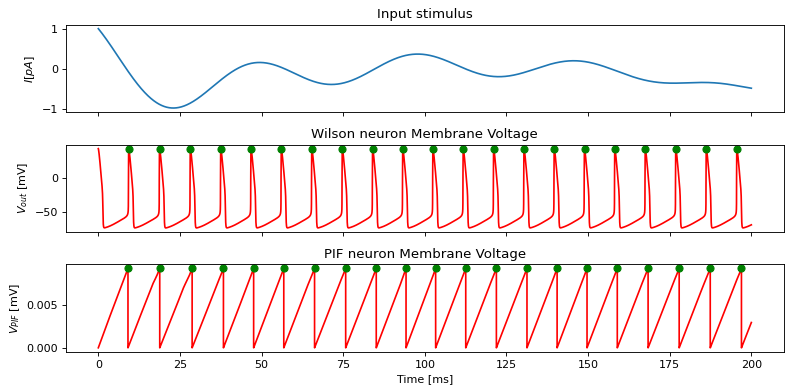

In [12]:
# TODO: Plot RHH, PIF outputs and compare the Inter-spike intervals (time_diff)
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(1e3 * t, u)
ax[0].set_title("Input stimulus")
ax[0].set_ylabel(r"$I [pA]$ ")

ax[1].plot(1e3 * t, V_rhh, label="Membrane Potential", color="red", zorder=0)
ax[1].scatter(
    1e3 * t[ref_idx],
    V_rhh[ref_idx],
    marker="o",
    color="green",
    s=40,
    label="Spike",
    zorder=1,
)
ax[1].set_title("Wilson neuron Membrane Voltage")
ax[1].set_ylabel(r"$V_{out}$ [mV]")

ax[2].plot(1e3 * t, V_pif, label="Membrane Potential", color="red", zorder=0)
ax[2].scatter(
    1e3 * t[pif_idx],
    V_pif[pif_idx],
    marker="o",
    color="green",
    s=40,
    label="Spike",
    zorder=1,
)
ax[2].set_title("PIF neuron Membrane Voltage")
ax[2].set_ylabel(r"$V_{PIF}$ [mV]")
ax[2].set_xlabel("Time [ms]")

fig.tight_layout()
plt.show()

Next, we plot the interspike intervals for the Wilson and PIF neurons. We see that the interspike intervals are quite close.

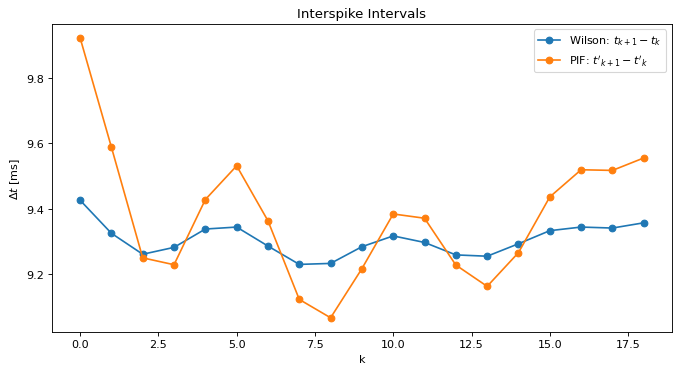

In [13]:
plt.plot(
    1e3 * dt * np.diff(ref_idx[1:]), '-o', label=r"Wilson: $t_{k+1} - t_{k}$"
)
plt.plot(
    1e3 * dt * np.diff(pif_idx[1:]), '-o', label=r"PIF: $t'_{k+1} - t'_{k}$"
)
plt.title("Interspike Intervals")
plt.xlabel("k")
plt.ylabel(r"$\Delta t$ [ms]")
plt.legend()
plt.show()

**Disclaimer** 

Note that in this assignment we asked to implement PIF with PRC, while in practice PIF should be implemented with iPRC instead. You will observe that the PIF generated with iPRC approximates the original neuron noticeably better than that with PRC.

In [14]:
# the implementation of iPRC is shown below
Code(inspect.getsource(iPRC), language='python')

def iPRC(
    model: BaseModel,
    dt: float,
    verbose: bool = False,
    spike_threshold: float = None,
    N_skip_cycles: int = 3,
    spike_variable: str = "V",
    normalize: bool = False,
    normalization_bias: float = 1e-15,
    lc: np.ndarray = None,
    limit_cycle_kws: tp.Mapping[str, float] = None,
    **injected_stimuli,
) -> tp.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute the phase response curve for a specified inject current value

    Arguments:
        model: instance of an oscillator class inherited from the parent class :code:`BaseModel`
        dt: temporal resolution for the ODE updates (in seconds)
        verbose: whether to show progress
        spike_threshold: minimum height to define the peak of a spike

            .. deprecated:: 0.1.3
                Use :code:`**limit_cycle_kws` instead

        N_skip_cycles: number of limit cycles to skip for psi computation to settle
        spike_variable: variable corresponding to voltage in the specified :code:`model`, this
          variable is used by :py:func:`limit_cycle` to find the limit cycle of the model.
        normalize: if `True`, will scale psi by product with gradient at each point along the limit
          cycle. Since the scaling involves a division, a small bias is added to the denominator which
          could result in spikes in the normalized psi. The bias can be controled by the
          `normalization_bias` parameter.
        normalization_bias: the bias term in the normalization of psi, see above.
        lc: limit cycle for the given model. If specified, the limit cycle computation is skipped.
        limit_cycle_kws: arguments to be passed into `limit_cycle` function

            .. seealso:: :py:func:"compneuro.utils.neuron.limit_cycle"

    Keyword Arguments:
        injected_stimuli: key,value pair of stimuls and constant value for that variable

    .. note::

        The model must have an ode method.
        Furthermore, the state variables of the model should be ordered such that
        voltage is the first variable.

    Returns:
        1. period: 1D array of time vector corresponding to the limit cycle
        2. limit_cycle: 2d numpy array of state variables over time
        3. psi: the desired iPRC of shape
          :code:`(number_of_states, period_length)`
    """
    model, Model = _check_is_instance(model)
    limit_cycle_kws = limit_cycle_kws if limit_cycle_kws is not None else {}

    if not hasattr(model, "ode"):
        raise err.CompNeuroUtilsError(
            "Error: this neuron model does not have an ode method"
        )
    if spike_threshold is not None:
        warn(
            (
                "spike_threshold argument is deprecated. Pass additional arguments to "
                "limit_cycle_kws as keyword arguments directly. This warning will become an "
                "error in the next minor release."
            ),
            DeprecationWarning,
        )
        if "height" not in limit_cycle_kws:
            if np.isscalar(spike_threshold):
                limit_cycle_kws.update({"height": spike_threshold})

    if lc is not None:
        assert lc.ndim == 2 and lc.shape[0] == len(
            model.Default_States
        ), f"Provided limit cycle is of shape ({lc.shape}), mismatched with model."
        t_lc = np.arange(lc.shape[1]) * dt
    else:
        spike_detect_args = {
            var: limit_cycle_kws.pop(var)
            for var in set(limit_cycle_kws.keys())
            - set(inspect.getfullargspec(limit_cycle).args)
        }
        t_lc, lc = limit_cycle(
            model,
            dt=dt,
            verbose=verbose,
            spike_variable=spike_variable,
            spike_detect_args=spike_detect_args,
            **limit_cycle_kws,
            **injected_stimuli,
        )
    period_lc = t_lc.max()

    # NOTE: for autonomous system that does not explicitly depend on `t`,
    # the following line could be replaced by
    # >>> np.vstack(model.ode(st

In [15]:
period_iprc, limit_cycle_iprc, psi = iPRC(rhh, I_ext=bias, dt=dt, verbose=True)

  0%|          | 0/1000000 [00:00<?, ?it/s]

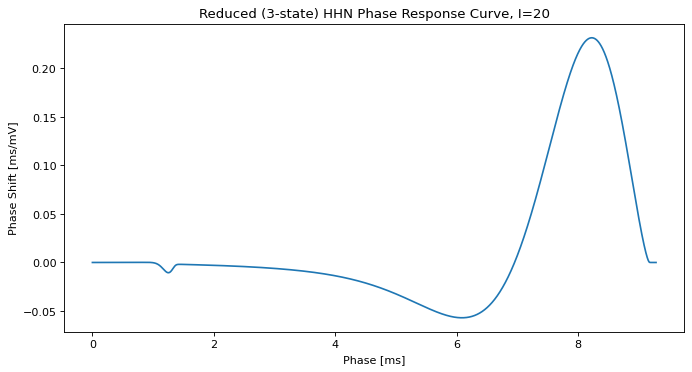

In [16]:
plt.plot(1e3 * period_iprc, psi[0])
plt.title("Reduced (3-state) HHN Phase Response Curve, I={}".format(bias))
plt.xlabel("Phase [ms]")
plt.ylabel("Phase Shift [ms/mV]")
plt.show()

In [17]:
ref_spikes = spike_detect(V_rhh)
ref_idx = np.where(ref_spikes)[0]
V_pif = PIF(t, u, psi[0])
prc_spikes = spike_detect(V_pif, distance=1000)
pif_idx = np.where(prc_spikes)[0]

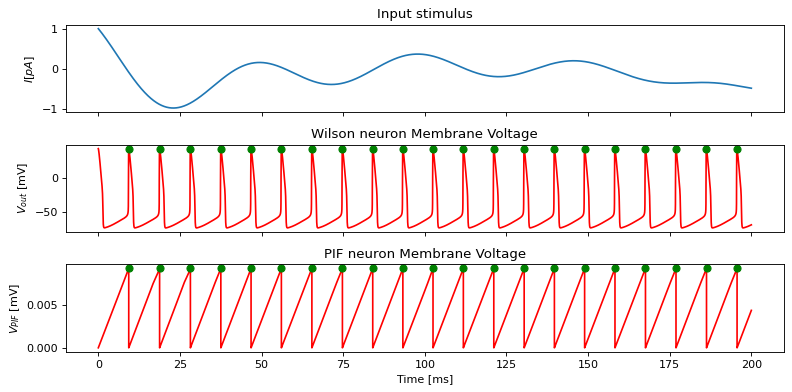

In [18]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(1e3 * t, u)
ax[0].set_title("Input stimulus")
ax[0].set_ylabel(r"$I [pA]$ ")

ax[1].plot(1e3 * t, V_rhh, label="Membrane Potential", color="red", zorder=0)
ax[1].scatter(
    1e3 * t[ref_idx],
    V_rhh[ref_idx],
    marker="o",
    color="green",
    s=40,
    label="Spike",
    zorder=1,
)
ax[1].set_title("Wilson neuron Membrane Voltage")
ax[1].set_ylabel(r"$V_{out}$ [mV]")

ax[2].plot(1e3 * t, V_pif, label="Membrane Potential", color="red", zorder=0)
ax[2].scatter(
    1e3 * t[pif_idx],
    V_pif[pif_idx],
    marker="o",
    color="green",
    s=40,
    label="Spike",
    zorder=1,
)
ax[2].set_title("PIF neuron Membrane Voltage")
ax[2].set_ylabel(r"$V_{PIF}$ [mV]")
ax[2].set_xlabel("Time [ms]")

fig.tight_layout()
plt.show()

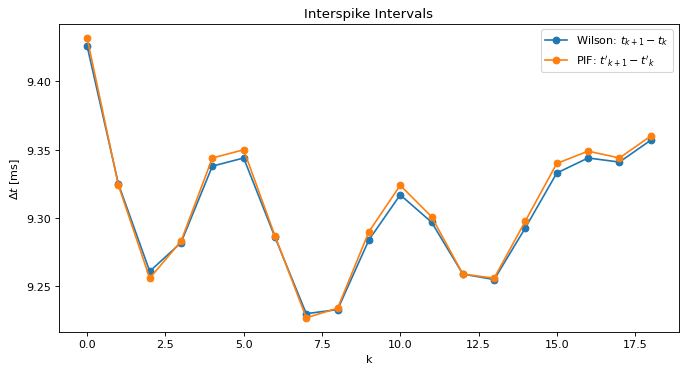

In [19]:
plt.plot(
    1e3 * dt * np.diff(ref_idx[1:]), '-o', label=r"Wilson: $t_{k+1} - t_{k}$"
)
plt.plot(
    1e3 * dt * np.diff(pif_idx[1:]), '-o', label=r"PIF: $t'_{k+1} - t'_{k}$"
)
plt.title("Interspike Intervals")
plt.xlabel("k")
plt.ylabel(r"$\Delta t$ [ms]")
plt.legend()
plt.show()

### Part 3. Estimate the mean and standard deviation of the difference in spike-times between a 3-state HH neuron and its corresponding PIF neuron.

In [20]:
# I = 20  # injected current
# period, limit_cycle, psi = PRC(rhh, I_ext=I, dt=dt, verbose=False)

c_arr = np.arange(0, 2.5, 0.25)  # range of values for c
n_trials = 5  # number of trials to average over for a given c

u_all = np.zeros((len(c_arr)*n_trials, len(t)))
for n in range(n_trials):
    u_all[n::n_trials] = np.outer(c_arr,  bandlmt_sig(t, 5, 20))  # stimulus current

In [21]:
rhh = HodgkinHuxley3State(num=len(c_arr) * n_trials, V=lc[0,0], n=lc[1,0], h=lc[2,0] )
rhh_res_all = rhh.solve(t, I_ext=bias+u_all.T, verbose="Solving RHH with all input values")

Solving RHH with all input values:   0%|          | 0/200001 [00:00<?, ?it/s]

In [22]:
spike_mask_all = spike_detect(rhh_res_all['V'], axis=1)
tk_idx_all = [np.where(mask)[0] for mask in spike_mask_all]
mean_arr = np.zeros_like(c_arr)
stdv_arr = np.zeros_like(c_arr)

ctr = 0
for i in range(len(c_arr)):
    err_isi = []
    for j in range(n_trials):
        V_pif = PIF(t, u_all[ctr], prc[0])
        prc_spikes = spike_detect(V_pif, distance=1000)
        pif_isi = np.diff(np.where(prc_spikes)[0]) * dt
        hhw_isi = np.diff(tk_idx_all[ctr]) * dt
        N_spikes = min([len(pif_isi), len(hhw_isi)])
        err_isi += (pif_isi[:N_spikes] - hhw_isi[:N_spikes]).tolist()
        ctr += 1

    mean_arr[i] = np.mean(err_isi)
    stdv_arr[i] = np.std(err_isi)

We now plot the mean and variance of the interspike timing error below.

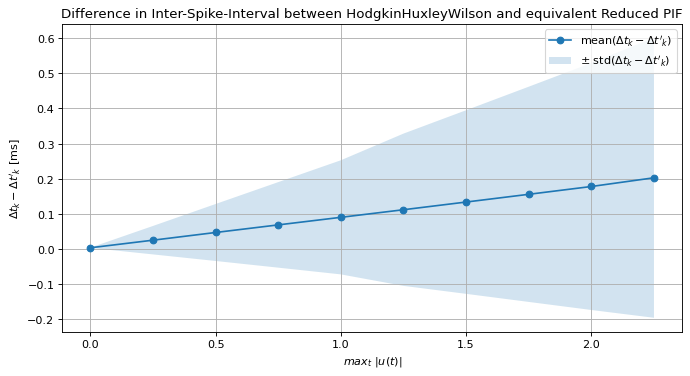

In [23]:
fig, ax = plt.subplots(1, 1, sharex=True)
ax.plot(c_arr, 1e3 * mean_arr, '-o', label="mean($\Delta t_k - \Delta t'_k$)")
ax.fill_between(c_arr, 1e3 * (mean_arr-stdv_arr), 1e3*(mean_arr+stdv_arr), alpha=.2, label="$\pm$ std($\Delta t_k - \Delta t'_k$)")
ax.set(
    ylabel=r"$\Delta t_k - \Delta t'_k$ [ms]", 
    xlabel=r"$max_t ~ |u(t)|$",
    title="Difference in Inter-Spike-Interval between HodgkinHuxleyWilson and equivalent Reduced PIF"
)
ax.grid()
ax.legend()

plt.show()

## Problem 2: Synaptic Input and PRC

In [24]:
from compneuro.neurons.hodgkin_huxley import HodgkinHuxley
from compneuro.synapses.ampa import AMPA
from compneuro.synapses.gaba_a import GABA_A
from compneuro.utils.neuron import limit_cycle
from compneuro.utils.phase_response import PIF, PRC, iPRC
from compneuro.utils.signal import spike_detect
import numpy as np
import matplotlib.pyplot as plt

In [25]:
dt = 1e-5
t = np.arange(0, 0.2, dt)

bias = 20  # injected current
# unit is in pico amp
# we suggest refering the injection current amplitude (aka without stimulus) 
# that you've experimented with in HW1 that gives robust firing 

rhh = HodgkinHuxley()
t_lc, lc = limit_cycle(rhh, dt, I_ext=bias)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [26]:
res = rhh.solve(t, I_ext=bias*np.ones_like(t), verbose=True)
V_rhh =res['V'][0]
n_rhh =res['n'][0]

  0%|          | 0/20000 [00:00<?, ?it/s]

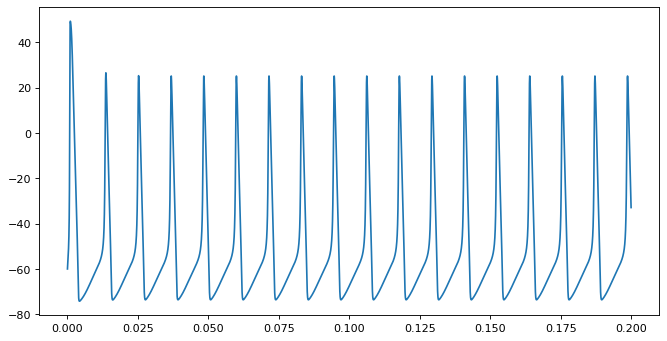

In [27]:
plt.plot(t,res['V'][0])

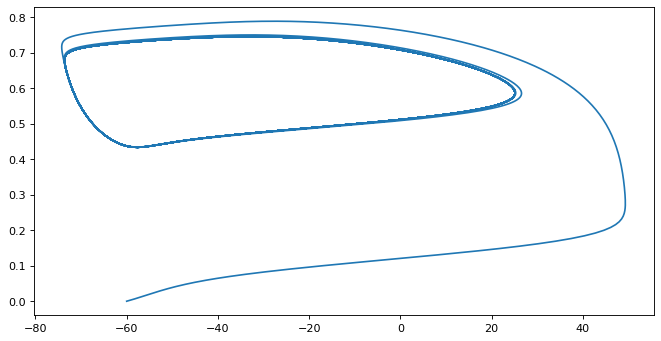

In [28]:
plt.plot(res['V'][0],res['n'][0])

In [29]:
# here we use iPRC but PRC would also work
period_iprc, limit_cycle_iprc, psi = iPRC(rhh, I_ext=bias, dt=dt, verbose=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

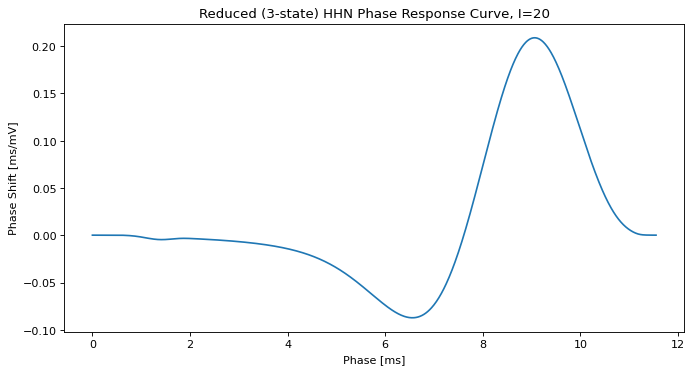

In [30]:
plt.plot(1e3 * period_iprc, psi[0])
plt.title("Reduced (3-state) HHN Phase Response Curve, I={}".format(bias))
plt.xlabel("Phase [ms]")
plt.ylabel("Phase Shift [ms/mV]")
plt.show()

In [31]:
np.where(np.logical_and(psi[0] +psi[0][656]<0.001 , psi[0] +psi[0][656]>-0.001))

(array([ 807, 1016]),)

In [32]:
ref_spikes = spike_detect(V_rhh)
ref_idx = np.where(ref_spikes)[0]
ref_idx

array([  101,  1363,  2525,  3682,  4838,  5995,  7151,  8308,  9464,
       10620, 11777, 12933, 14090, 15246, 16403, 17559, 18716, 19872])

In [33]:
period_iprc[np.argmin(psi[0])] /dt, period_iprc[np.argmax(psi[0])] /dt

(655.9999999999995, 905.9999999999998)

In [34]:
prc_min = np.argmin(psi[0])
prc_max = np.argmax(psi[0])

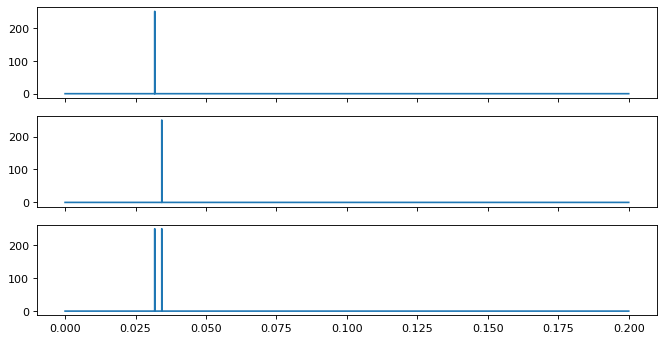

In [35]:
c=250
spike=2
NT_min,NT_max=np.zeros_like(t),np.zeros_like(t)
NT_min[prc_min+ref_idx[spike]]=c
NT_max[prc_max+ref_idx[spike]]=c
NT_both =NT_max +NT_min

fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(t,NT_min)
ax[1].plot(t,NT_max)
ax[2].plot(t,NT_both)

In [36]:
def sim_postsyn(synapse,bias, NT):

    syn = synapse
    res = syn.solve(t=t, I_ext=NT, verbose=False, solver="Euler")
    s = res["s"][0]
    g = syn.conductance(s=s)

    hh = HodgkinHuxley()
    Isyn = np.zeros_like(t)
    Vpost = np.zeros_like(t)
    npost=np.zeros_like(t)
    Vpost[0] = hh.states["V"]
    for i in range(len(t) - 1):
        Isyn[i + 1] = -g[i + 1] * (Vpost[i] - syn.params["E"])
        hh.state_arr += (
            dt
            * hh.Time_Scale
            * np.vstack(hh.ode(t=i, states=hh.state_arr, I_ext=bias+Isyn[i + 1]))
        )
        Vpost[i + 1] =  hh.states["V"] 
        npost[i+1] =hh.states["n"]

    return Isyn,Vpost,npost

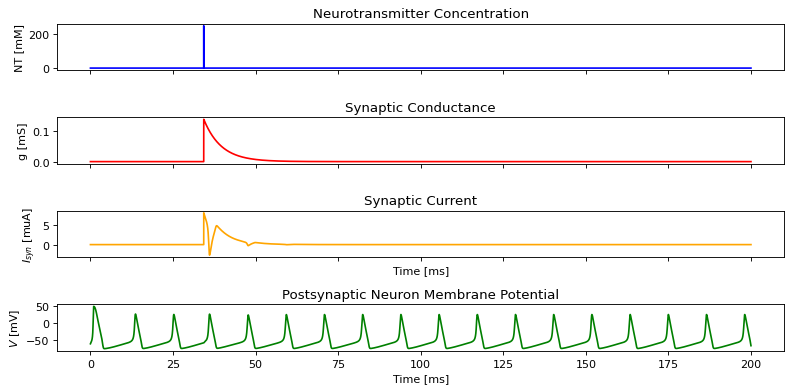

In [37]:
syn = AMPA()
res = syn.solve(t=t, I_ext=NT_max, verbose=False, solver="Euler")
s = res["s"][0]
g = syn.conductance(s=s)

hh = HodgkinHuxley()
Isyn = np.zeros_like(t)
Vpost = np.zeros_like(t)
npost=np.zeros_like(t)
Vpost[0] = hh.states["V"]
for i in range(len(t) - 1):
    Isyn[i + 1] = -g[i + 1] * (Vpost[i] - syn.params["E"])
    hh.state_arr += (
        dt
        * hh.Time_Scale
        * np.vstack(hh.ode(t=i, states=hh.state_arr, I_ext=bias+Isyn[i + 1]))
    )
    Vpost[i + 1] =  hh.states["V"] 
    npost[i+1] =hh.states["n"]


fig, ax = plt.subplots(4, 1, sharex=True)

ax[0].plot(1e3 * t, NT_max, color="blue")
ax[0].set_title("Neurotransmitter Concentration")
ax[0].set_ylabel("NT [mM]")

ax[1].plot(1e3 * t, g, label="Synaptic Conductance", color="red")
ax[1].set_title("Synaptic Conductance")
ax[1].set_ylabel("g [mS]")

ax[2].plot(1e3 * t, Isyn, label="Synaptic Current", color="orange")
ax[2].set_title("Synaptic Current")
ax[2].set_ylabel(r"$I_{syn}$ [muA]")
ax[2].set_xlabel("Time [ms]")

ax[3].plot(1e3 * t, Vpost, label="Membrane Voltage", color="green")
ax[3].set_title("Postsynaptic Neuron Membrane Potential")
ax[3].set_ylabel(r"$V$ [mV]")
ax[3].set_xlabel("Time [ms]")

fig.tight_layout()
plt.show()

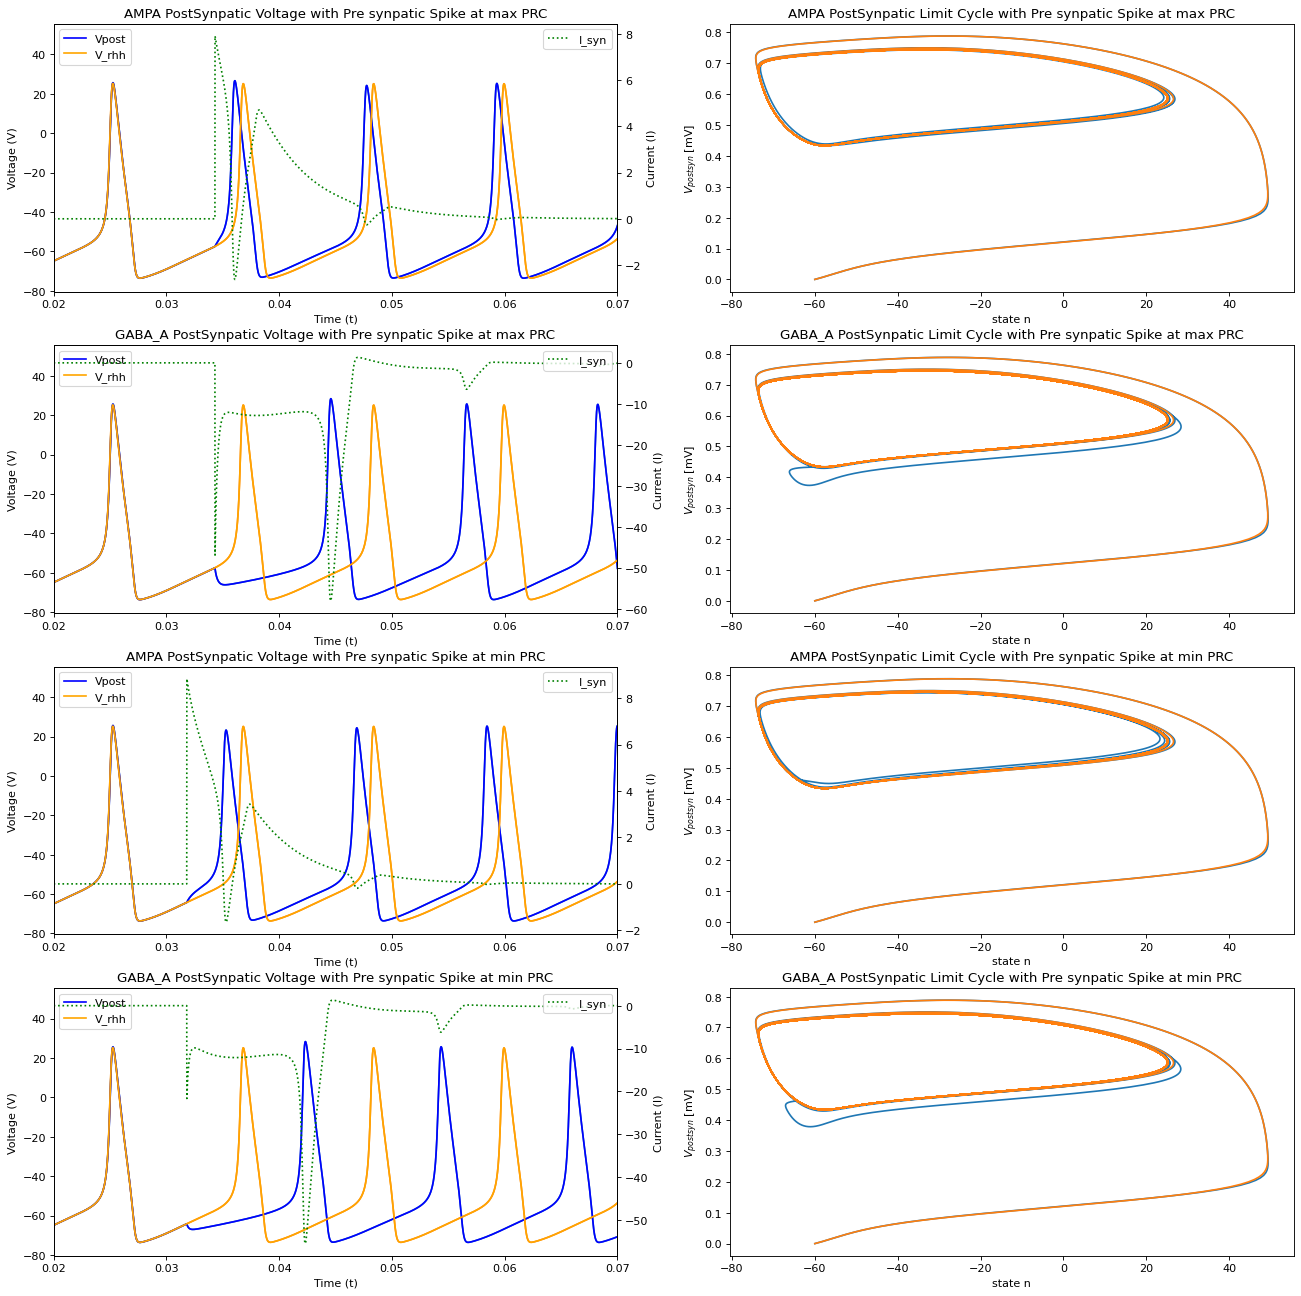

In [38]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(20,20)
i=0
for NT,nt_name in zip([NT_max, NT_min],["Spike at max PRC","Spike at min PRC"]):
    for synapse,syn_name in zip([AMPA(), GABA_A()],["AMPA","GABA_A"]):
        Isyn,Vpost,npost= sim_postsyn(synapse,bias,NT)

        ax[i,0].plot(t,Vpost,t,V_rhh)
        ax[i,0].set_xlim(0.02,0.07)
        ax[i,0].set_title(f"{syn_name} PostSynpatic Voltage with Pre synpatic {nt_name}")
        ax[i,0].set_ylabel(r"$V_{postsyn}$ [mV]")
        ax[i,0].set_xlabel("Time [ms]")

        ax[i, 0].plot(t, Vpost, label='Vpost',color='b')
        ax[i, 0].plot(t, V_rhh, label='V_rhh',color='orange')

        ax2 = ax[i, 0].twinx()  # Create a twin Axes sharing the xaxis
        ax2.plot(t, Isyn, 'g', label='I_syn',linestyle=':')  # 'g' for green color, you can choose any color you like

        ax[i, 0].set_xlabel('Time (t)')
        ax[i, 0].set_ylabel('Voltage (V)')
        ax2.set_ylabel('Current (I)')

        # Optionally, add legends to identify the lines.
        ax[i, 0].legend(loc='upper left')
        ax2.legend(loc='upper right')



        ax[i,1].plot(Vpost,npost,V_rhh,n_rhh)
        ax[i,1].set_title(f"{syn_name} PostSynpatic Limit Cycle with Pre synpatic {nt_name}")
        ax[i,1].set_ylabel(r"$V_{postsyn}$ [mV]")
        ax[i,1].set_xlabel("state n")
        i+=1

## Winfree Method without Compneuro

In [ ]:
def winfree_method_HH(t,dt,I_bias,winfree_step,spike_detect_thre):
    
    '''
    Function that implement winfree's method to extract PRCs of the HH model 
    
    Assumption for winfree's method: 
        small pertubation v on the membrane voltage injected at time between 
        base spike time t_k and t_k+1 
        
    The PRC is calulated as the difference between base spike time t_k+1 and 
    spike time t_k+1': 
        PCR = t_k+1 - t_k+1' 
        
    [INPUT PARAMETERS]: 
        t --- time vector, unit is in (s) 
        dt --- time step size 
        I_bias --- base current that keep the neuron firing (traveling around limit cycle)
        winfree_step --- number of phases we want to inject current at 
        spike_detect_thre --- the voltage threshold for spike detection
        
    [OUTPUT PARAMETERS]: 
        t_lc --- time vector (s) of one limit cycle (start at 0s)
        res_arr --- results of all state variables corresponding to impulse injected at different phase;
                    res_arr[0] is the state variables of base model (without perturbation)
        PRCs --- numpy array in the format of [normalize phase, t_k+1 - t_k+1']
        
    '''
    hh = HodgkinHuxley()
    res_arr = []

    # simulate without perturbation   
    I_ext = I_bias * np.ones_like(t)
    res = hh.solve(t, I_ext=I_ext, verbose=False)
    v1 = res["V"][0]
    n1 = res["n"][0]
    h1 = res["h"][0]
    m1 = res["m"][0]

    res_arr.append(res)

    ref_idx = spike_detect(v1, thresh=spike_detect_thre)
    ref_idx = np.where(ref_idx)[0]
    print('base spike time squence:', t[ref_idx])

#     limit_cycle = np.array([v1,n1,h1,m1])

    spike_t_0 = ref_idx[1] # spike time t_k index number
    spike_t_1 = ref_idx[2] # spike time t_k+1 index number 
    
    period = [ref_idx[1], ref_idx[2]] # lower and upper bound (index number) of period for one limit cycle 
    t_lc = np.arange(0,spike_t_1-spike_t_0-2,1)*dt


    # simulate with perturbations at at different phases
    p_amp = 0.1  # perturbation amplitude
    p_range = np.linspace(ref_idx[1], ref_idx[2], winfree_step)  # pertubation indices

    PRCs = []
    
    for i, pid in enumerate(p_range):
        
        hh.states["V"] = v1[round(pid)] + p_amp
        hh.states["n"] = n1[round(pid)] 
        hh.states["h"] = h1[round(pid)] 
        hh.states["m"] = h1[round(pid)] 

        res_new = hh.solve(
            t[round(pid) :], 
            I_ext=I_ext[round(pid) :],
            reset_initial_state=False,
            verbose=False
        )

        v_new = res_new["V"][0]
        n_new = res_new["n"][0]
        h_new = res_new["h"][0]
        m_new = res_new["m"][0]
        
        #detect the new spike time t_k+1' after impulse v
        ref_idx = spike_detect(v_new, thresh=spike_detect_thre)            
        ref_idx = np.where(ref_idx)[0] 
        spike_time_new = ref_idx[0] + round(pid) #index number 
        
        impulse_injected_time = round(pid) #index number 
        normalized_phase = (pid-period[0])/(period[1]-period[0])

        #append the data
        PRCs.append([normalized_phase, t[spike_t_1]-t[spike_time_new] ])
    
    #correct the timeshift at normalized phase = 1, it is zero 
    PRCs[-1] = [1, 0]
    
    return t_lc, res_arr, np.array(PRCs)